# One Exampe of Implicit Neural Representations for DWI

In [1]:
import os
import warnings
import numpy as np
import scipy.io as sio
import mat73
import torch
import copy
from multiprocessing import Pool
from INRmodel import calculate_combinations, ImageFitting_set, Siren, PN, input_mapping, get_mgrid, calculate_ADC, resize_array
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.transform import rescale
from skimage.metrics import structural_similarity as ssim

### Set some hyperparameters

In [4]:
headers_for_quantitative_results = 'Pt_id, b-value, slice, SSIM-spline, SSIM-SR\n'
mapping_size = 128
hidden_dim = 512
scale = 0.5
num_layers = 3
PN_dim = 128
roi_start = 40
roi_end = 90 
number_of_epochs = 2500
pertubation_epochs = 10 #This corresponds to 1200 steps total for each acquisition
pt_id = 89

### Load Data

In [7]:
data_address = f'/home/gundogdu/Desktop/pat{pt_id:03d}/master2.mat'
output_address = f'/home/gundogdu/Desktop/SR_results_test5/pat{pt_id:03d}'
if not os.path.exists(output_address):
    os.makedirs(output_address)
file = open(os.path.join(output_address, 'ssim_scores.csv'), mode='w')
file.write(headers_for_quantitative_results)
print('Loading data')
try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address)
print('Data loaded')

Loading data
Data loaded


In [12]:
hybrid_raw = data['hybrid_raw_clean']
image_shape = hybrid_raw[0][0].shape
hybrid_raw_norm = copy.deepcopy(hybrid_raw)
maxes = np.zeros((4,4))
print(f'{hybrid_raw.shape}')
print(f'{hybrid_raw[3][0].shape}')

(4, 4)
(128, 128, 21, 12)


In [13]:
for b in range(4):
    for te in range(4):
        maxes[b, te] = hybrid_raw_norm[b][te].max()
        hybrid_raw_norm[b][te] = hybrid_raw_norm[b][te]/maxes[b, te]
        num_processes = 32
pool = Pool(processes=num_processes)
voxel_list = [(i, j, k) for i in range(image_shape[0])
                        for j in range(image_shape[1])
                        for k in range(image_shape[2])]


In [14]:

print('Calculating all combinations in parallel')
results = pool.starmap(calculate_combinations, [(voxel, hybrid_raw_norm) for voxel in voxel_list])
pool.close()
pool.join()
acquisitions = np.zeros((image_shape[0], 
            image_shape[1], 
            image_shape[2],
            4,
            hybrid_raw[1][0].shape[3]*hybrid_raw[2][0].shape[3]*hybrid_raw[3][0].shape[3]))

for idx, voxel in enumerate(voxel_list):
    i, j, k = voxel
    acquisitions[i, j, k, :, :] = results[idx]

print('Done calculating')
select_acquisitions = np.squeeze(acquisitions)
mean_img = np.mean(select_acquisitions,-1)

Calculating all combinations in parallel
Done calculating


### Now creating the dataset for INR

In [16]:
img_dataset = []
for inx in range(select_acquisitions.shape[-1]):
    img = select_acquisitions[roi_start:roi_end:2, roi_start:roi_end:2, :, :, inx]
    img_dataset.append(img)

mean_dataset = ImageFitting_set([mean_img[roi_start:roi_end:2, roi_start:roi_end:2, :]])
dataset = ImageFitting_set(img_dataset)
dimension = len(dataset.shape)
HR = ImageFitting_set([mean_img[roi_start:roi_end, roi_start:roi_end, :]])

/home/gundogdu/inr3/lib64/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Initializing the INR and PerturbNet model 

In [17]:
B_gauss = np.random.normal(size=(mapping_size, dimension))
B = torch.from_numpy(B_gauss * scale).float().cuda()

INR = Siren(in_features=2*mapping_size, out_features=1, 
                hidden_features=hidden_dim,
                hidden_layers=num_layers)

INR.cuda()
PerturbNet = PN(in_features=2*mapping_size, hidden_features=PN_dim, dimension=dimension)
PerturbNet.cuda()

inr_params = list(INR.parameters())
inr_optim = torch.optim.Adam(lr=5e-5, params=inr_params)
perturb_params = list(PerturbNet.parameters())
perturb_optim = torch.optim.Adam(lr=1e-6, params=perturb_params)
torch.cuda.empty_cache()

LR_ground_truth, model_input  = mean_dataset.pixels[0].cuda(), mean_dataset.coords[0].cuda()
model_input = input_mapping(model_input, B)
HR_model_input  = HR.coords[0]#.cuda()
HR_model_input = input_mapping(HR_model_input, B.cpu())
test_input_shape = (HR.shape[0]*2, HR.shape[1]*2, HR.shape[2], HR.shape[3])
test_input  = input_mapping(get_mgrid(test_input_shape), B.cpu())

HR_img = mean_img[roi_start:roi_end, roi_start:roi_end, :, :]

### Training Begins

In [18]:
print(f'Training the INR and Perturb-Net for mapping size = {mapping_size} and sigma = {scale}')
for ctr in tqdm(range(number_of_epochs)):
    if ctr < number_of_epochs - pertubation_epochs:
        model_output = INR.forward(model_input)
        loss = ((model_output - LR_ground_truth)**2).mean()
        inr_optim.zero_grad()
        loss.backward()
        inr_optim.step()
    else:
        if ctr%2:
            model_output = INR.forward(model_input)
            loss = ((model_output - LR_ground_truth)**2).mean()
            inr_optim.zero_grad()
            loss.backward()
            inr_optim.step()
        else:
            for sample in range(len(dataset)):
                ground_truth  = dataset.pixels[sample].cuda()
                perturbed_input = PerturbNet.forward(model_input, sample, 1/128.)
                perturbed_input = input_mapping(perturbed_input, B)
                model_output = INR.forward(perturbed_input)

                loss = ((model_output - ground_truth)**2).mean()
                perturb_optim.zero_grad()
                loss.backward()
                perturb_optim.step()

print('Training finished, now creating outputs')

Training the INR and Perturb-Net for mapping size = 128 and sigma = 0.5


100%|██████████| 2500/2500 [01:27<00:00, 28.48it/s]

Training finished, now creating outputs


### Creating Sample outputs

In [20]:
test_input = test_input.cpu()
HR_model_input = HR_model_input.cpu()
INR.cpu()
B = B.cpu()

bvalues = data['b']
recon = torch.clamp(INR.forward(test_input), min=0).view(test_input_shape).detach().numpy()
SR_recon = torch.clamp(INR.forward(HR_model_input), min=0).view(HR.shape).detach().numpy()
_slice = 10

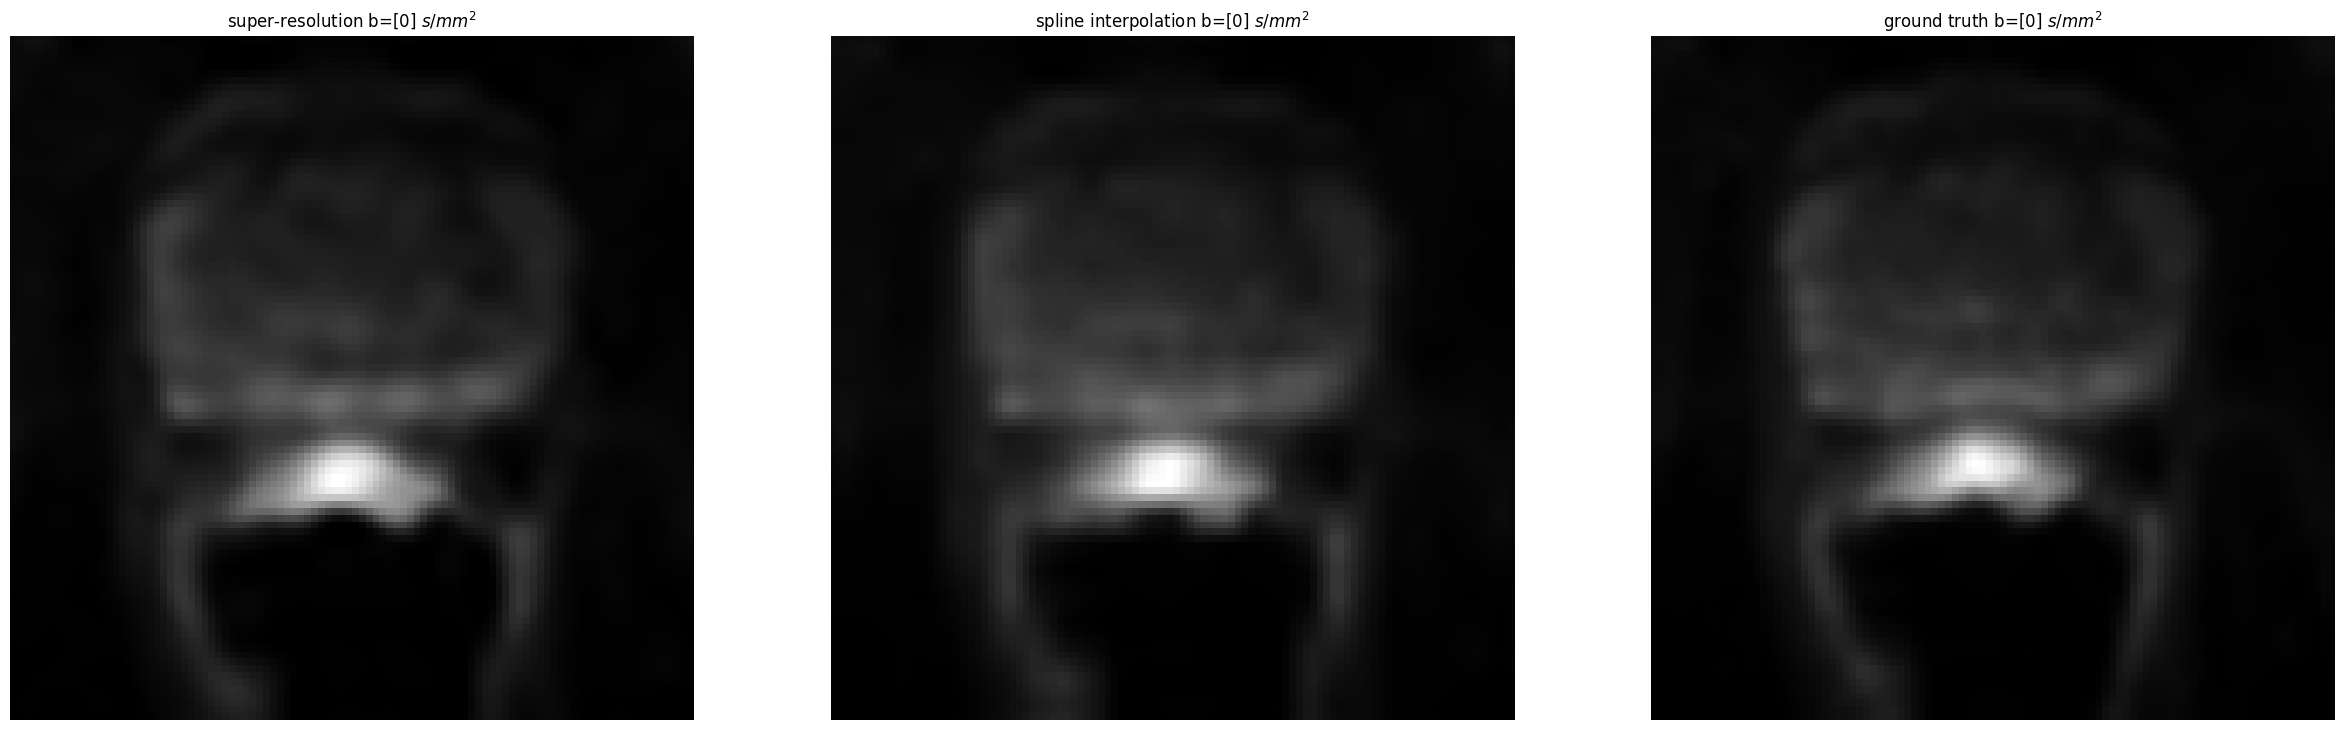

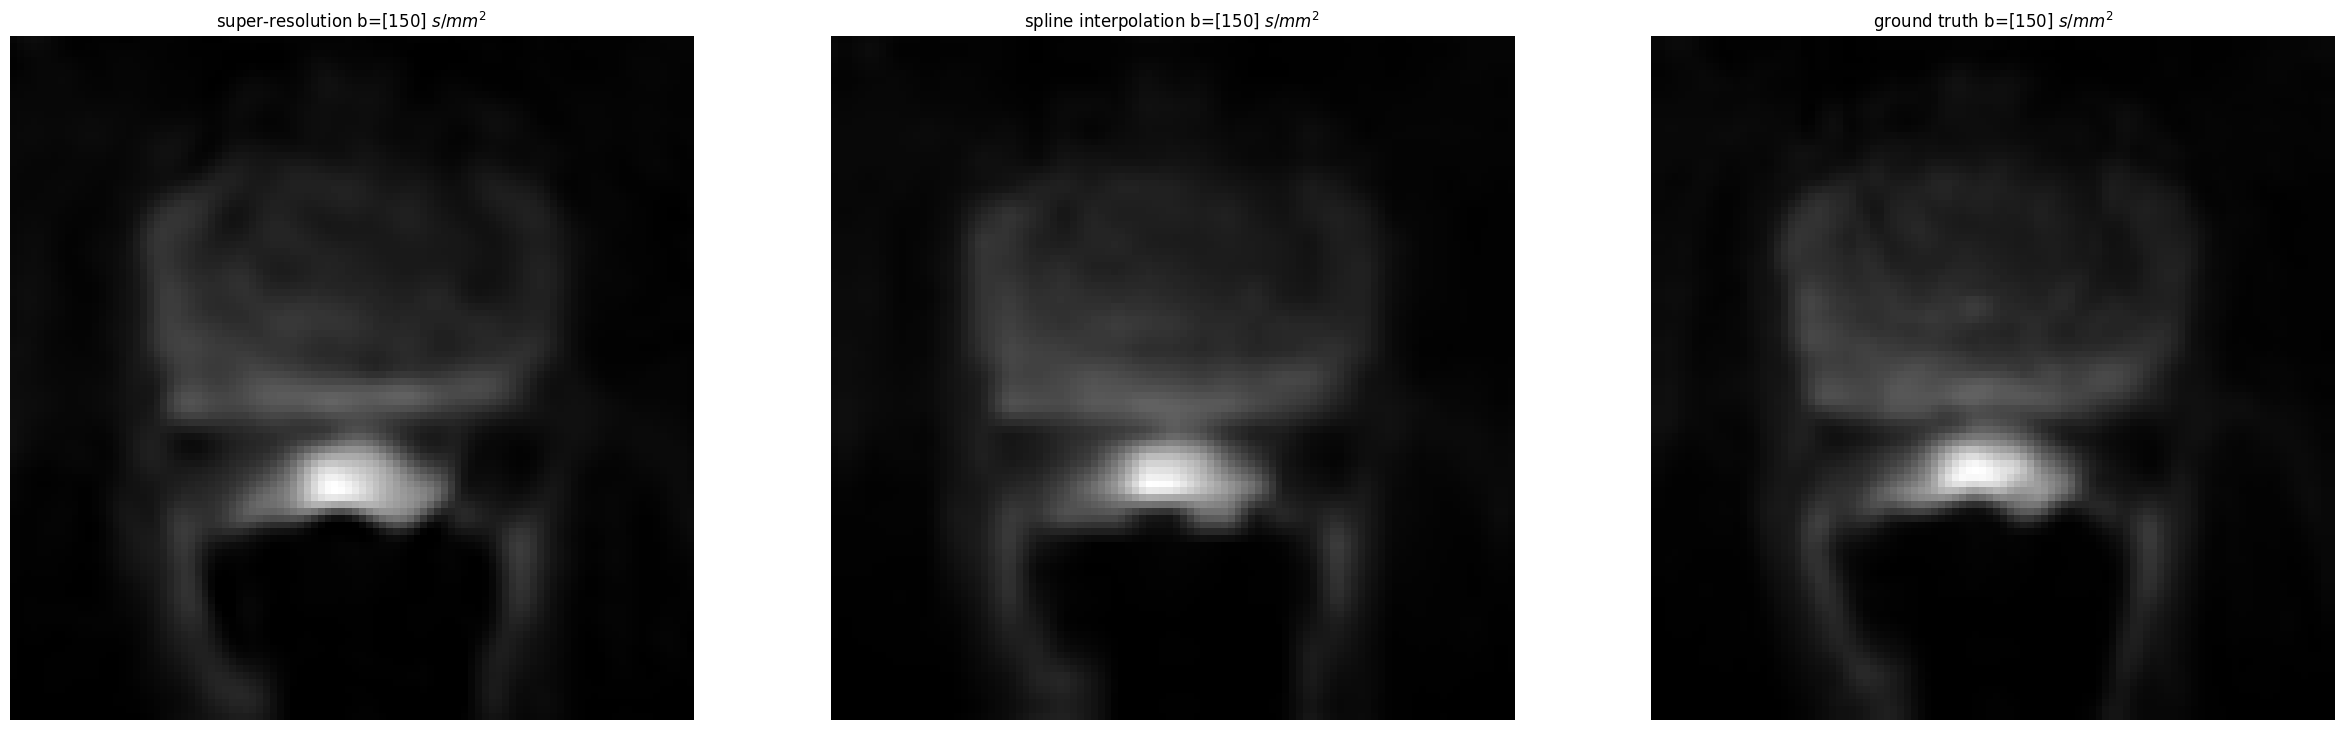

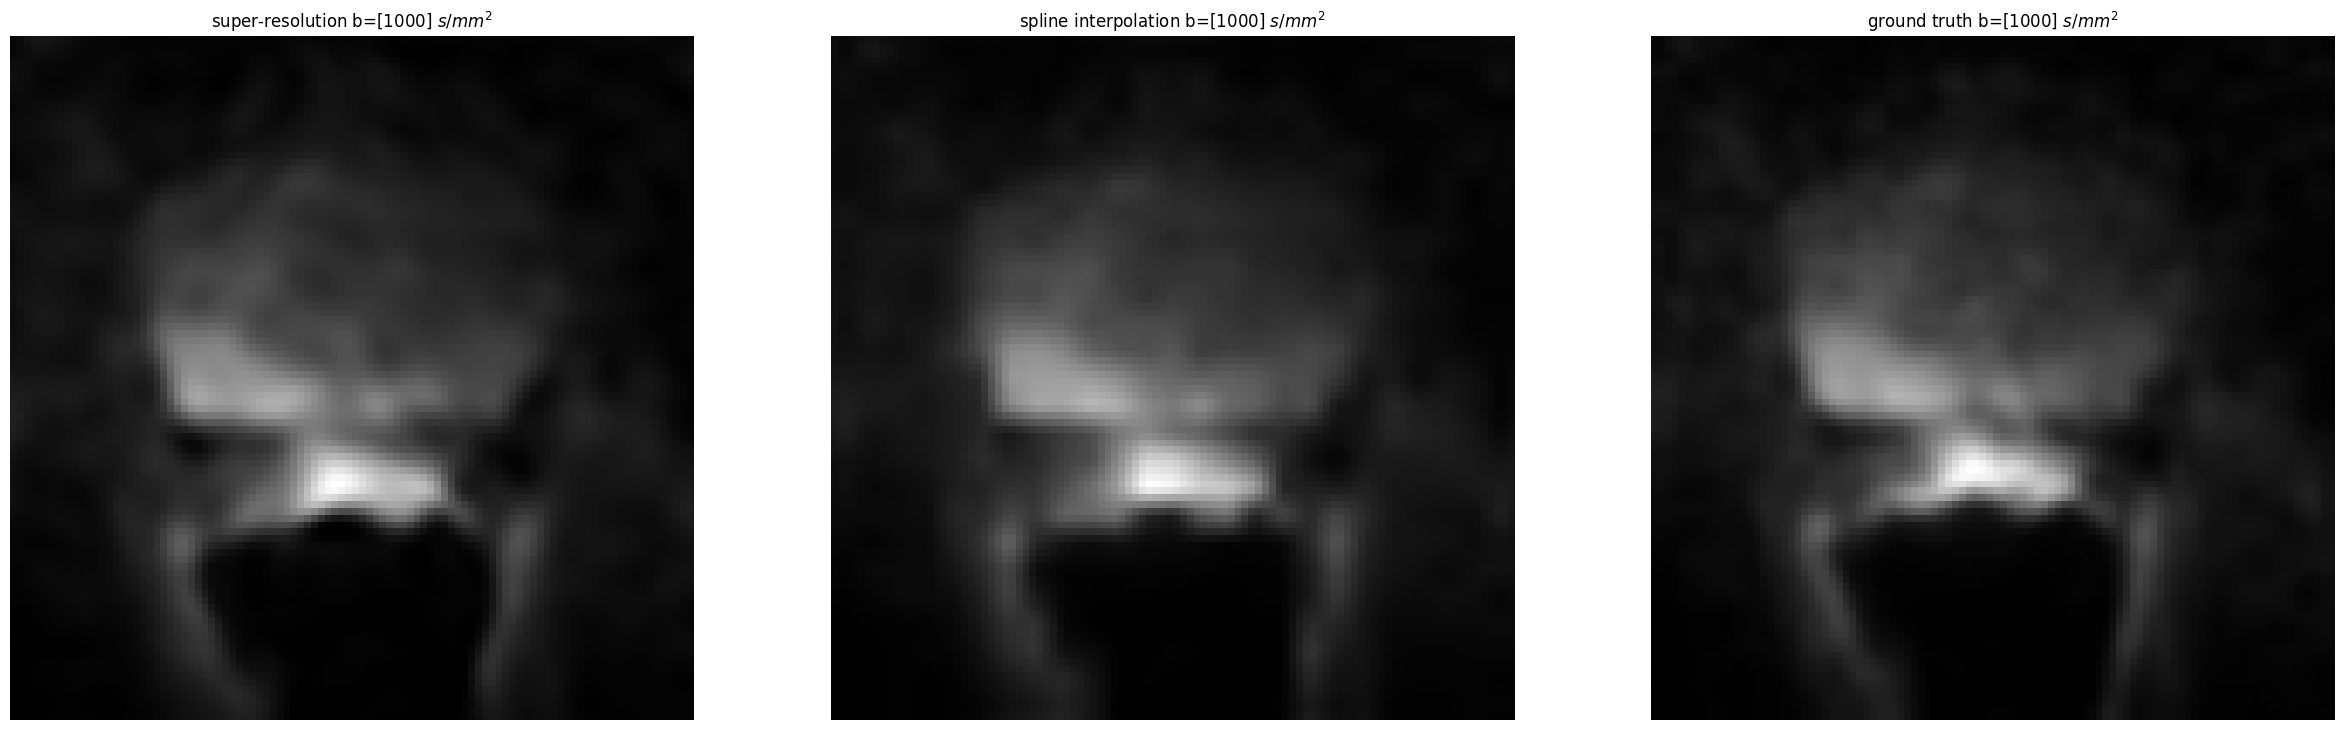

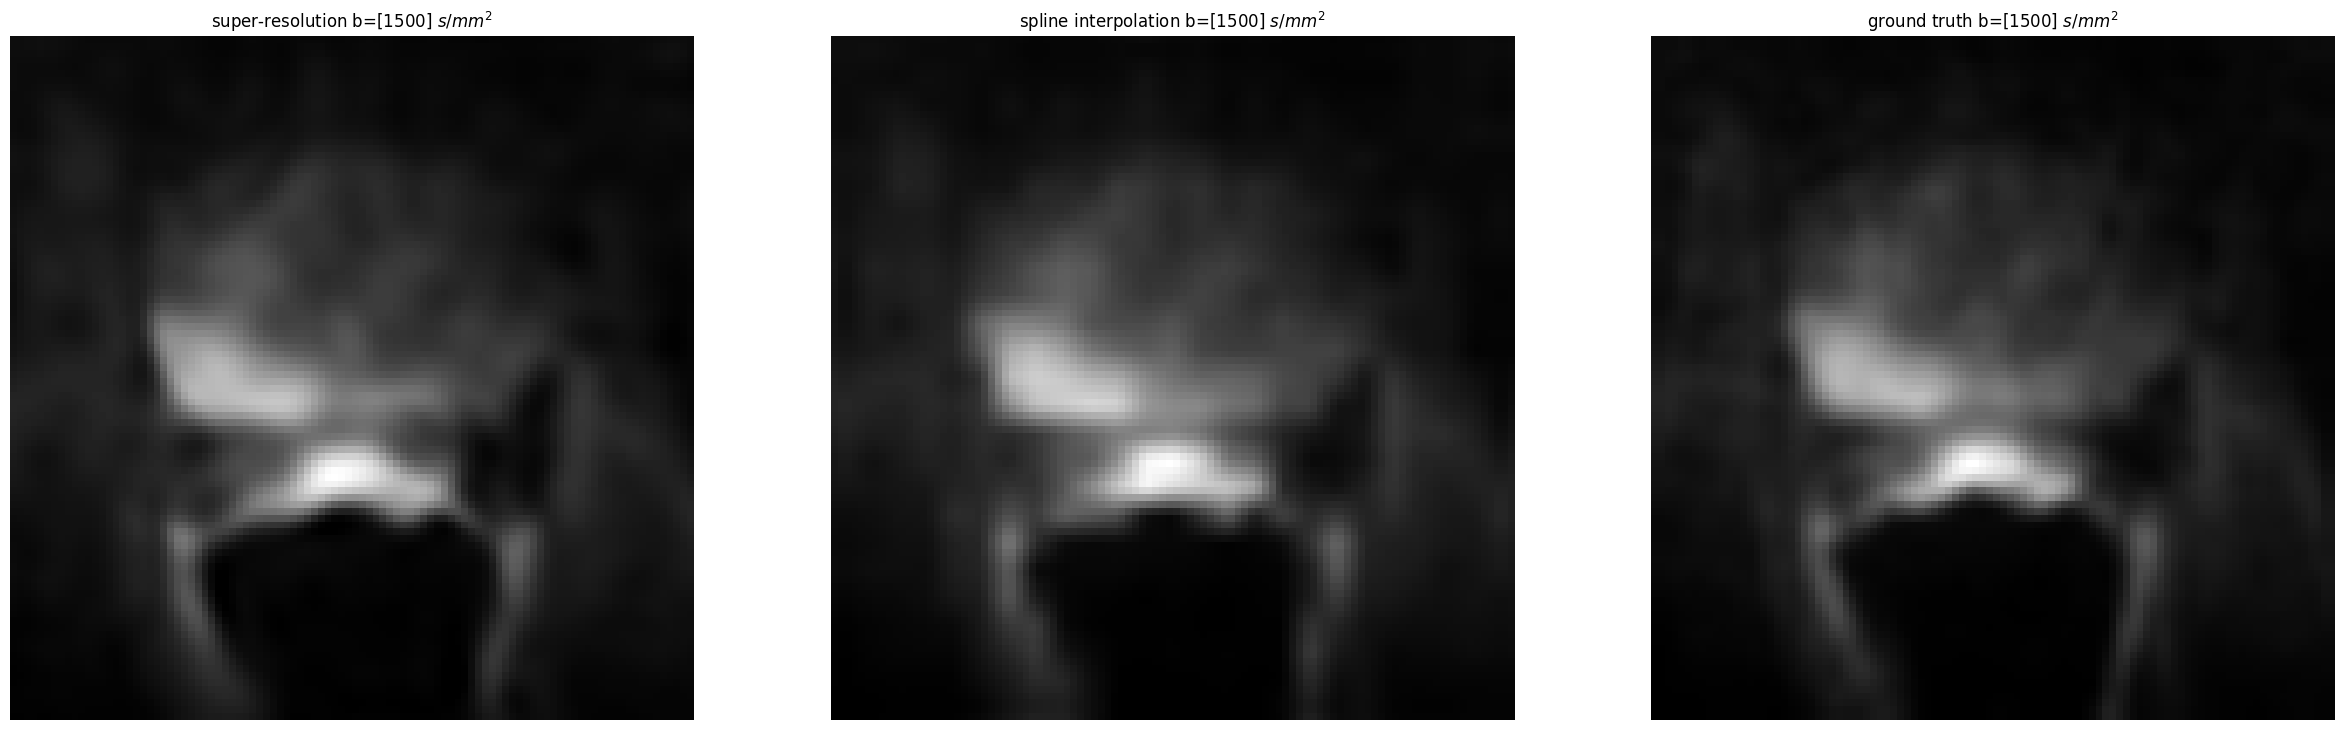

In [22]:
recon_rescaled = np.zeros((test_input_shape[0], test_input_shape[1], len(bvalues)))
HR_rescaled = np.zeros((test_input_shape[0], test_input_shape[1], len(bvalues)))
spline_rescaled = np.zeros((test_input_shape[0], test_input_shape[1], len(bvalues)))
for b in range(4): 
    _, ax = plt.subplots(1,3, figsize=(30,10))
    ax[0].imshow(recon[:, :, _slice, b], cmap='gray')
    ax[0].set_title(f'super-resolution b={bvalues[b]} $s/mm^2$')
    ax[1].imshow(rescale(mean_img[roi_start:roi_end:2,roi_start:roi_end:2, _slice, b], 4, anti_aliasing=True), cmap='gray')
    ax[1].set_title(f'spline interpolation b={bvalues[b]} $s/mm^2$')
    ax[2].imshow(rescale(mean_img[roi_start:roi_end, roi_start:roi_end, _slice, b], 2, anti_aliasing=True), cmap='gray')
    ax[2].set_title(f'ground truth b={bvalues[b]} $s/mm^2$')
    for axi in range(3):
        ax[axi].axis('off')

    HR_ref = HR_img[:, :, _slice, b]
    HR_ref = HR_ref/HR_ref.max()
    spline = rescale(HR_img[::2, ::2, _slice, b], 2, anti_aliasing=True)
    spline = spline/spline.max()
    SR = SR_recon[:, :, _slice, b]
    SR = SR/SR.max()
    mask = HR_ref > 0.05 # As suggested by Gourdeu et. al (2022) Medical Physics
    row_to_file = f'{pt_id}, {bvalues[b]}, {_slice}, {ssim(HR_ref*mask, spline*mask, data_range=1)}, {ssim(HR_ref*mask, SR*mask, data_range=1)}\n'
    file.write(row_to_file)

    recon_rescaled[:, : , b] = (recon[:, :, _slice, b])*maxes[b, 0] #Note, we took the TE=57 to match the clinical DWI
    spline_rescaled[:, : , b] = rescale(mean_img[roi_start:roi_end:2,roi_start:roi_end:2, _slice, b], 4, anti_aliasing=True)*maxes[b, 0] 
    HR_rescaled[:, : , b] = rescale(mean_img[roi_start:roi_end, roi_start:roi_end, _slice, b], 2, anti_aliasing=True)*maxes[b, 0] 

    plt.show()


### Calculating the Super-resolved ADC using all generted b-values

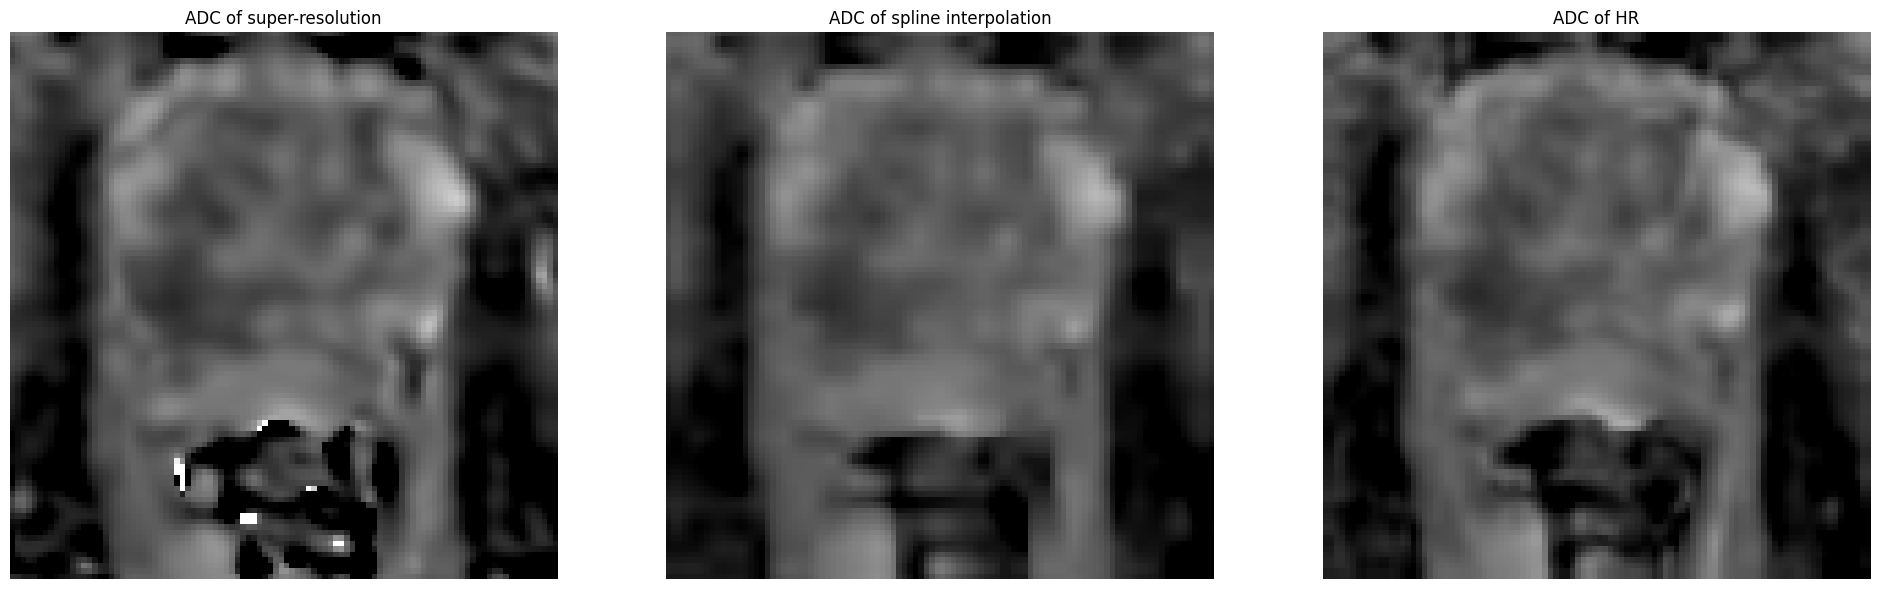

In [23]:
_, ax = plt.subplots(1,3, figsize=(24,8))
adc = calculate_ADC(bvalues, recon_rescaled)
ax[0].imshow(adc,  vmin=0.3, vmax = 3., cmap='gray')
ax[0].set_title(f'ADC of super-resolution')
adc = calculate_ADC(bvalues, spline_rescaled)
ax[1].imshow(adc,  vmin=0.3, vmax = 3., cmap='gray')
ax[1].set_title(f'ADC of spline interpolation')
adc = calculate_ADC(bvalues, HR_rescaled)
ax[2].imshow(adc,  vmin=0.3, vmax = 3., cmap='gray')
ax[2].set_title(f'ADC of HR')
for axi in range(3):
    ax[axi].axis('off')

plt.show()

### Running the same model along the slice-select direction to obtain coronal view

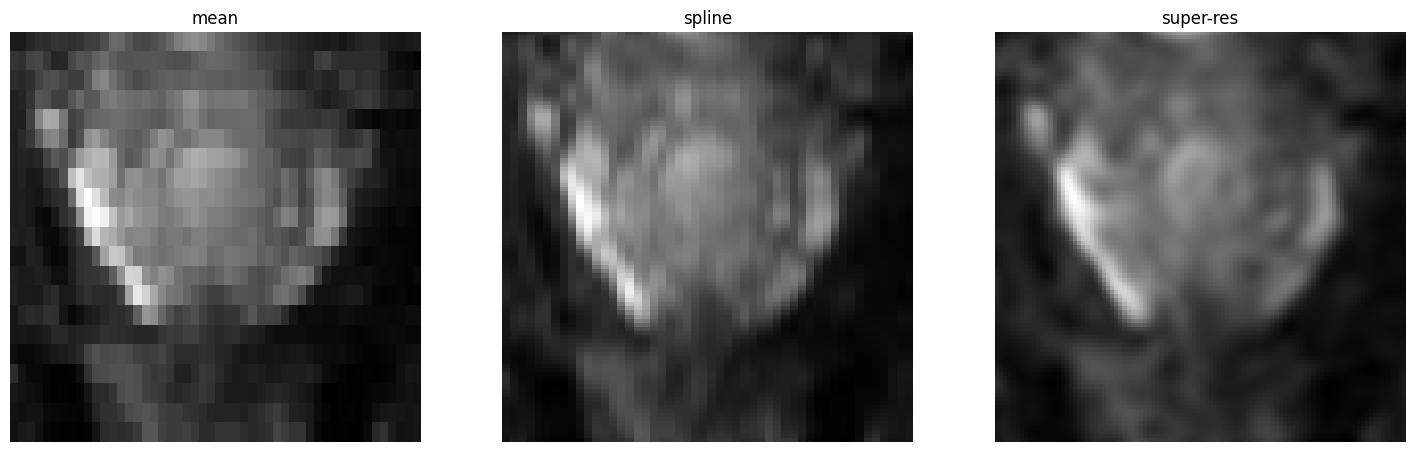

In [24]:
transverse_length = 100
coronal_shape = (test_input_shape[0], test_input_shape[1], transverse_length, 1)
model_input  = get_mgrid(coronal_shape)
model_input  = input_mapping(model_input, B)
recon = INR.forward(model_input).view(coronal_shape).detach().numpy()



_slice = 56
_, ax = plt.subplots(1, 3, figsize=(18,6))

ax[0].imshow(np.flipud(mean_img[_slice, roi_start:roi_end, :, 0 ].T), cmap='gray')
ax[0].set_title('mean')
ax[0].set_aspect((roi_end-roi_start)/test_input_shape[2])
spline = resize_array(mean_img[:, :, :, 0], transverse_length) # spline interpolation along z-direction
ax[1].imshow(np.flipud(spline[_slice, roi_start:roi_end , :].T), cmap='gray')
ax[1].set_aspect((roi_end-roi_start)/transverse_length)
ax[1].set_title('spline')
ax[2].imshow(np.flipud(recon[(_slice - roi_start)*2, :, :, 0].T), cmap='gray')
ax[2].set_title(f'super-res')
for axi in range(3):
    ax[axi].axis('off')

plt.show()

